In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here we calculate the theoretical power output of a induction generator consisting of cylindrical magnet moving along the z axis in a periodic fashion.

The approach is the following:
* Discretize the coil into M sections.
* For each section apply Faradays law to get the electric field along 


In [2]:
def plot(t, V, R, f = None):
    # Induced current (Ohm's Law)
    I = V / R

    # Power generated
    P = V * I



    print("Calculated Resistance: ", R)
    print("Constant Power Generated: ", P.mean())

    # Plotting the results
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, V)


    
    plt.title('Induced Voltage')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')

    plt.subplot(3, 1, 2)
    plt.title('Induced Current')
    plt.plot(t, I)
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')

    plt.subplot(3, 1, 3)
    plt.plot(t, P)
    plt.title('Generated Power')
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')

    if (f is not None):
        # Add a secondary plot that shows the aplitude of the motion.
        # A new axis will be needed because the magnitude of the movement is different to that of voltage.
        z = np.vectorize(f)(t) # Calculate the position of the magnet at each time step.
        ax2 = plt.gca().twinx()
        ax2.plot(t, z, 'r--')
        
    plt.tight_layout()
    plt.show()

Resistance of the coil: 6.72 ohms


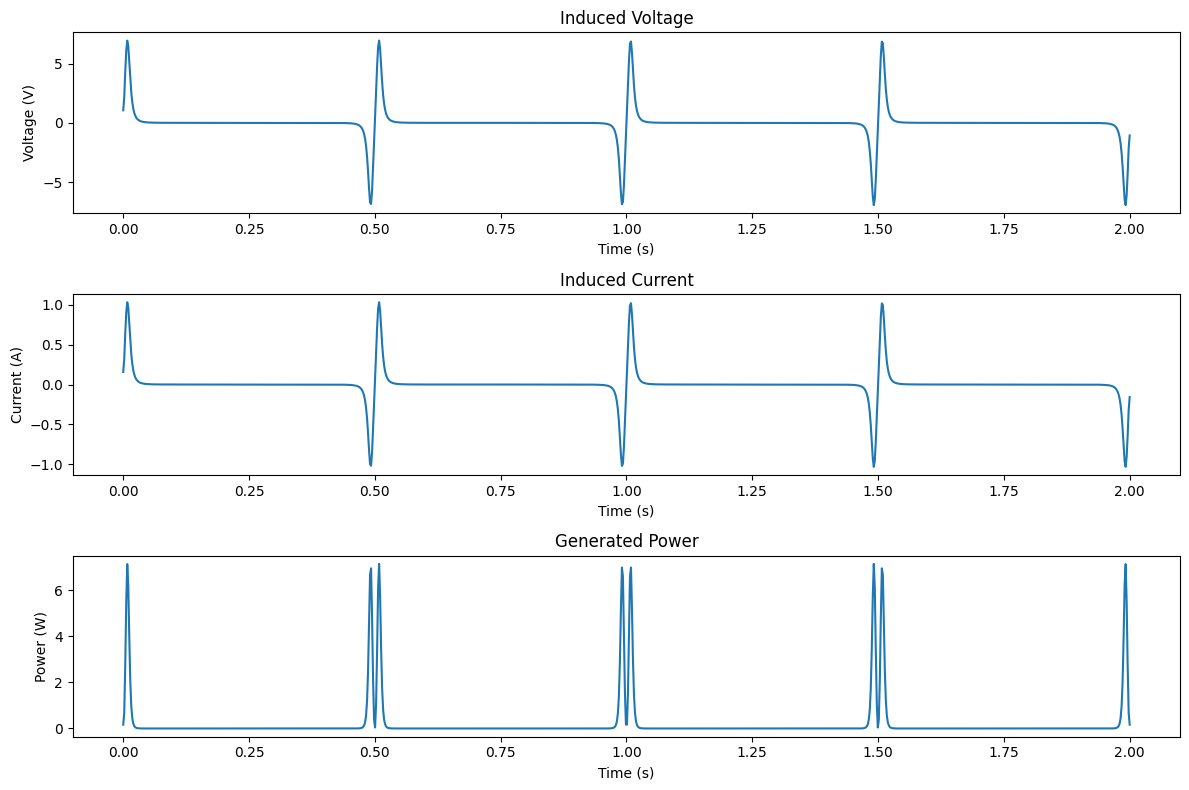

In [3]:
# Parameters
z0 = 1  # Amplitude of the motion (m)
omega = 2 * np.pi * 1  # Angular frequency (rad/s)
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)
m = 1  # Magnetic moment (A*m^2)
coil_length = 0.1  # Length of the coil (m)
num_segments = 100  # Number of segments to divide the coil

# Calculate the resistance of the coil
N = 1000  # Number of turns in the coil
coil_radius = 0.05  # Radius of the coil in meters (5 cm)
d_wire = 0.001  # Diameter of the wire in meters (1 mm)
L_wire = 2 * np.pi * coil_radius * N
A_wire = np.pi * (d_wire / 2)**2
rho_copper = 1.68e-8  # Resistivity of copper in ohm meters
R = rho_copper * L_wire / A_wire

# Time array
t = np.linspace(0, 2, 1000)  # Time from 0 to 2 seconds

# Magnet motion
z = z0 * np.sin(omega * t)
dz_dt = z0 * omega * np.cos(omega * t)

# Computational parameters
discretization = 1000  # Discretization of the coil

# Discretize the coil
segment_length = coil_length / discretization
z_segments = np.linspace(-coil_length / 2, coil_length / 2, discretization)

# Magnetic field B at the coil
def magnetic_field(z, z_segment, r, m, mu0):
    return (mu0 / (4 * np.pi)) * (2 * m) / (((z - z_segment) ** 2 + r ** 2) ** (3 / 2))

def magnetic_flux_at_z(z, z_segment, r, m, mu0):
    B = magnetic_field(z, z_segment, r, m, mu0)
    A = np.pi * r ** 2
    return B * A

# Calculates the electric field at the coil at z. Z can be a vector.
def electric_field_at_z(z, z_segment, r, m, mu0, N, omega):
    # Calculate the magnetic flux through a disc at z.
    flux = magnetic_flux_at_z(z, z_segment, r, m, mu0)


# Calculate the magnetic flux through each segment and sum them up
def total_flux(z, z_segments, coil_radius, num_segments):
    A = np.pi * coil_radius ** 2  # Area of the coil
    flux = np.zeros_like(z)
    for z_seg in z_segments:
        B = magnetic_field(z, z_seg, coil_radius, m, mu0)
        flux += B * A / num_segments
    return flux

# Compute total magnetic flux
Phi = N * total_flux(z, z_segments, coil_radius, num_segments)

# Induced voltage (Faraday's Law)
V = -np.gradient(Phi, t)

# Induced current (Ohm's Law)
I = V / R

# Power generated
P = V * I


print("Resistance of the coil: {:.2f} ohms".format(R))

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, V)
plt.title('Induced Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.subplot(3, 1, 2)
plt.plot(t, I)
plt.title('Induced Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')

plt.subplot(3, 1, 3)
plt.plot(t, P)
plt.title('Generated Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')

plt.tight_layout()
plt.show()

Shape of the flux:  ()
Total magnetic flux through the disc: 0.00962376751744351 T*m^2


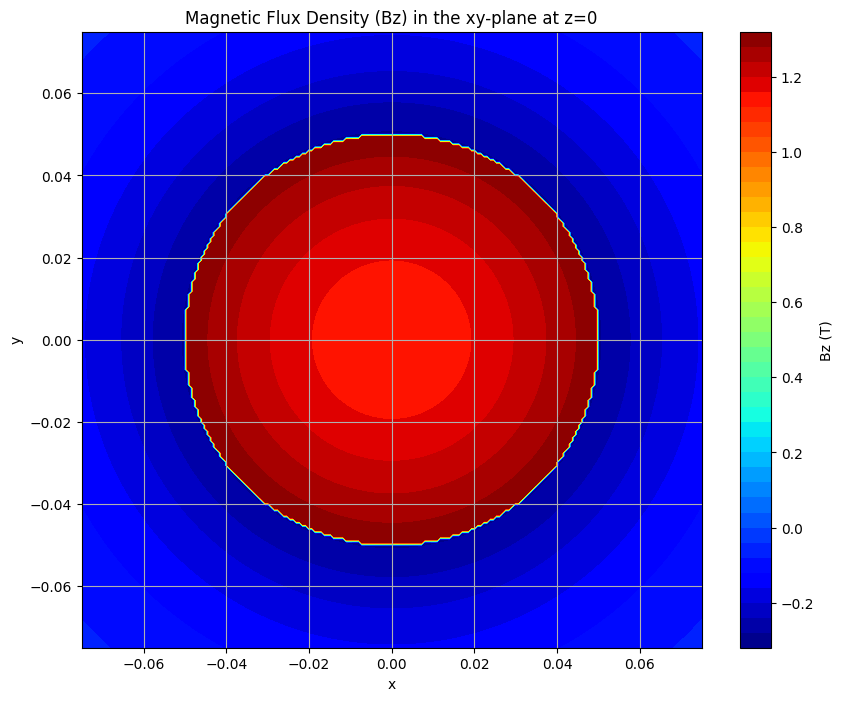

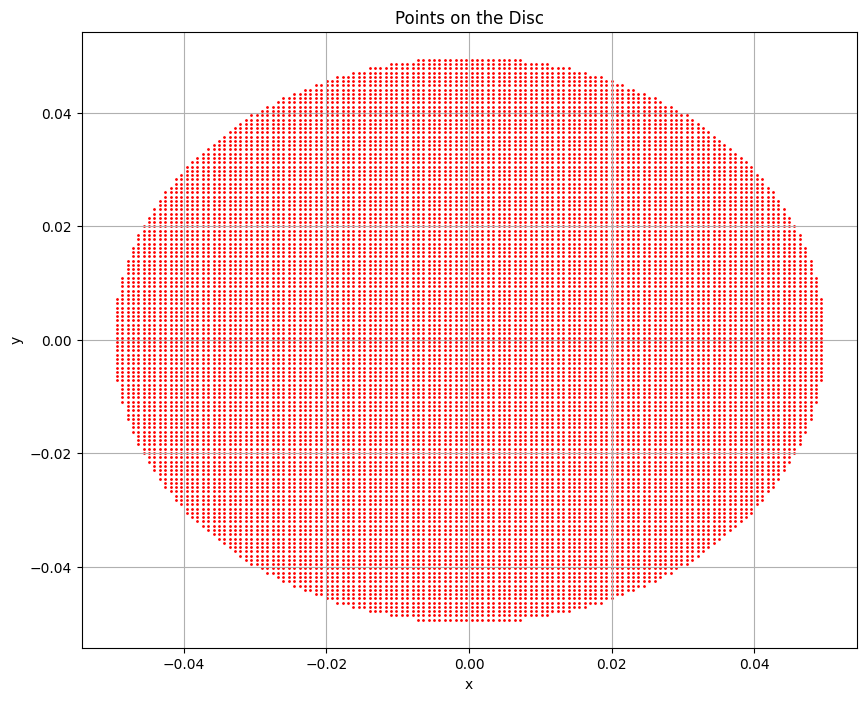

Number of points on the disc:  13796 (13796, 3)
Total magnetic flux through the disc (points):  0.009622441487390228
Area of the disc:  0.007853981633974483


In [4]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt

magnetization_of_neodymium_magnet = 1.27e6
# Magnet parameters

magnetization = magnetization_of_neodymium_magnet  # Magnetization direction and magnitude
cylinder_radius = 0.05  # Radius of the cylinder in arbitrary units
cylinder_length = 0.1  # Length of the cylinder in arbitrary units
discretization = 3

# Discretization parameters
z_segments = np.linspace(-cylinder_length / 2, cylinder_length / 2, 3)  # Segments along the z-axis


def create_cylinder_magnet(radius, length, magnetization=magnetization):
    """
    Create a cylindrical magnet using magpylib.
    
    Parameters:
    - magnetization: Magnetization vector
    - radius: Radius of the cylinder
    - length: Length of the cylinder
    
    Returns:
    - Cylindrical magnet object
    """
    magnet = magpy.magnet.Cylinder(magnetization=(0, 0, magnetization), dimension=(radius * 2, length))
    return magnet


def create_optimized_multi_cylinder_magnet(radius, magnet_length, number_of_magnets, gap, magnetization, use_alternation=False):
    """
    Create an object consisting of multiple cylinder magnets. The magnets are aligned on the z-axis and have a gap between them.
    
    Parameters:
    - radius: Radius of the cylinder (m)
    - magnet_length: Length of each cylinder (m)
    - number_of_magnets: Number of cylinder magnets
    - gap: Gap between the cylinders (m)
    - magnetization: Magnetization vector (A/m)
    - use_alternation: If set to True, alternates the polarity of neighboring magnets
    
    Returns:
    - Multi-cylinder magnet object centered at the origin
    """
    cylinders = []
    
    for i in range(number_of_magnets):
        cylinders.append(magpy.magnet.Cylinder(
            magnetization=(0, 0, -magnetization if i % 2 == 1 and use_alternation else magnetization),
            dimension=(radius * 2, magnet_length),
        ))
    
    # Create a collection to hold the magnets
    collection = magpy.Collection(*cylinders)
    
    # Calculate the total length of the magnet system including gaps
    total_length = number_of_magnets * magnet_length + (number_of_magnets - 1) * gap
    
    # Calculate the starting position to center the system
    start_z = -total_length / 2 + magnet_length / 2
    
    # Position each magnet
    for i, cylinder in enumerate(cylinders):
        z_position = start_z + i * (magnet_length + gap)
        cylinder.move((0, 0, z_position))
    
    return collection

def plot_magnet(magnet_collection):
    """
    Plot the 3D view of the magnet collection.
    
    Parameters:
    - magnet_collection: A magpylib Collection object containing the magnets
    """
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    # Add displaySystem on ax1
    magpy.show(magnet_collection, canvas=ax1, suppress=True)
    ax1.view_init(elev=20, azim=30)  # Set perspective to more side view
    
    plt.show()


# Create a cylindrical magnet
magnet = create_cylinder_magnet(cylinder_radius, cylinder_length, magnetization)

# Vectorized function to evaluate the magnetic flux density at given points (r, z)
def calculate_flux(z, magnet, z_segments, disc_radius, r_discretization):
    """
    Calculate the magnetic flux through a set of discs at positions of z_segments.

    Args:
        z (float): The offset position of the magnet from the origin.
        magnet: The magnet object used to calculate the magnetic flux 
        z_segments (array-like): The array of z-coordinates for each disc that the flux is calculated through.
        disc_radius (float): The radius of the discs.
        r_discretization (int): An integer representing the granularity of discretization in the radial direction.
    
    Returns:
        array-like: An array containing the magnetic flux through each z and disc. Shape is (len(z), len(z_segments)).
    """

    # For efficiency we buld a tensor that contains the z-coordinates of the discs for each z position.
    #z_segments_aug = np.expand_dims(z_segments, axis=0) + z  # Add the z offset to each z-segment
    z_positions = ((z_segments[..., np.newaxis] - z).T).flatten()

    r_segments = np.linspace(0, disc_radius, r_discretization)  # Radial segments
    # Find the points between each radial segment.
    middle_r = (r_segments[1:] + r_segments[:-1]) / 2
    R, Z = np.meshgrid(middle_r, z_positions)  # Create a grid of r and z points
    X = R.flatten()
    Y = np.zeros_like(X)
    Z = Z.flatten()

    # Calculate the magnetic flux density at all points
    B = magnet.getB(np.column_stack((X, Y, Z)))

    Bz = B[:, 2]  # Extract the z-component of the magnetic flux density


    # The Bz entries start from the first z, z-segment and middle radius, visit each middle radius value in the z-segment, and then move to the next z-segment, visit each z-segment and the move to the next z.
    # We need to calculate the flux for each segment. 
    # Calculate the flux through each segment by multiplying the area of the annular sector by the magnetic flux density at the middle radius of the segment.    

    annular_areas = np.pi * (r_segments[1:] ** 2 - r_segments[:-1] ** 2)  # Area of each slice of the disc
    annular_areas = np.tile(annular_areas, len(z_positions)) # Repeat the annular areas for each z-segment. (These are the same for each z-segment.)
    flux_elements = annular_areas * Bz # Multiply the area by the magnetic flux density to get the flux through each annular sector.
    flux_through_segment = flux_elements.reshape((len(z), len(z_segments), len(middle_r))).sum(axis=2) # Sum the flux through each annular sector to get the total flux through each z-segment.

    
    return flux_through_segment

# Calculate the magnetic flux through the disc
flux = calculate_flux(np.array([0, 0.01]), magnet, np.array([0, 0.005]), cylinder_radius, 200)[0][0]
print("Shape of the flux: ", flux.shape)
print(f"Total magnetic flux through the disc: {flux} T*m^2")


# Optional: visualize the magnetic field along a plane
x = np.linspace(-1.5 * cylinder_radius, 1.5 * cylinder_radius, 200)
y = np.linspace(-1.5 * cylinder_radius, 1.5 * cylinder_radius, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Vectorized magnetic field calculation
points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
B = magnet.getB(points)
Bz = B[:, 2].reshape(X.shape)

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Bz, levels=50, cmap='jet')
plt.colorbar(label='Bz (T)')
plt.title(f"Magnetic Flux Density (Bz) in the xy-plane at z={0}")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Sanity check
# Calculate the magnetic flux through the disc by taking the points on the disc.

# Filter the points on the disc
points_on_disc = points[np.linalg.norm(points[:, :2], axis=1) <= cylinder_radius]

# Plot the points on the disc
plt.figure(figsize=(10, 8))
plt.scatter(points_on_disc[:, 0], points_on_disc[:, 1], c='r', s=1)
plt.title("Points on the Disc")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# Assume that the points on the disc represent area elements.
# Calculate the area of each element.
area_element = np.pi * cylinder_radius ** 2 / len(points_on_disc)
print("Number of points on the disc: ", len(points_on_disc),  points_on_disc.shape)

# Get the field density at the points on the disc
b = magnet.getB(points_on_disc)
flux_points = np.sum(np.dot(b, area_element))
print("Total magnetic flux through the disc (points): ", flux_points)

print("Area of the disc: ", np.pi * cylinder_radius ** 2)


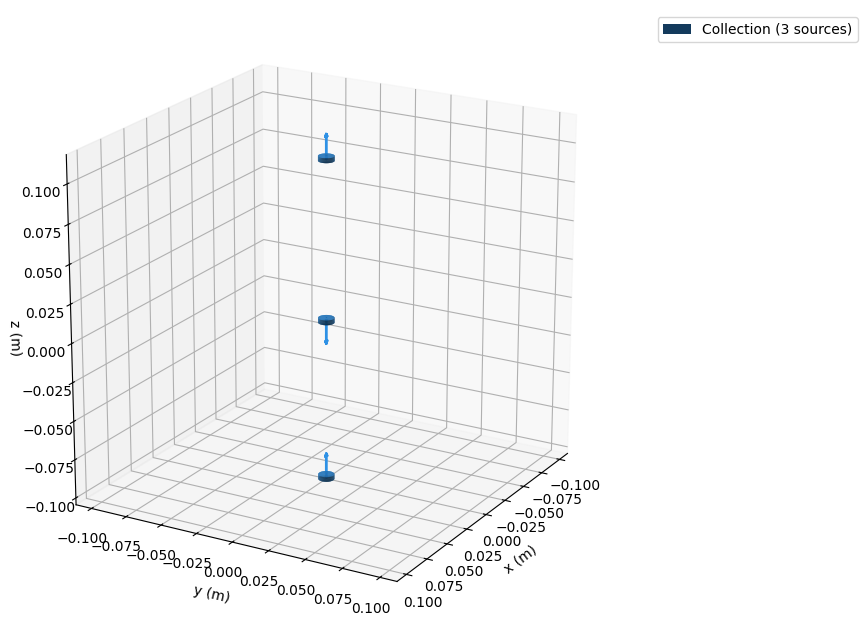

In [5]:
# Parameters
radius = 0.005  # Radius in meters
magnet_length = 0.003  # Length in meters
number_of_magnets = 3  # Number of magnets
gap = 0.1  # Gap between magnets in meters
magnetization = 1.27e6  # Magnetization in A/m

# Create the multi-cylinder magnet system
multi_cylinder_magnet = create_optimized_multi_cylinder_magnet(radius, magnet_length, number_of_magnets, gap, magnetization, use_alternation=True)

plot_magnet(multi_cylinder_magnet)

In [6]:
# Magnetic field B at the coil
def magnetic_field(z, z_segment, r, m, mu0):
    return (mu0 / (4 * np.pi)) * (2 * m) / (((z - z_segment) ** 2 + r ** 2) ** (3 / 2))


# Calculate the voltage across the coil by summing up the voltages across the coil segments.
# t: Time array
# z: Position of the magnet
# z_segments: Position array of the coil segments
# r: Radius of the coil
# m: Magnetic moment
# mu0: Permeability of free space
# N: Number of turns in the coil
# coil_length: Length of the coil
# segment_length: Length of the coil segment
def calculate_voltage_old(t, z, z_segments, r, m, mu0, N, coil_length, segment_length):



    def magnetic_flux_at_z(z, z_segment, r, m, mu0):
        B = magnetic_field(z, z_segment, r, m, mu0) # Simplistic assumption of constant magnetic field at the disc.
        A = np.pi * r ** 2
        return B * A
    
    V = np.zeros_like(z)
    for z_seg in z_segments:
        # For each segment we use Faradays law to calculate the voltage.
        # Faradays law states that the integral over a closed loop of the electric field is equal to the negative rate of change of the magnetic flux through the loop.
        # Let the loop be at z_seg and have radius r.
        B = magnetic_flux_at_z(z, z_seg, r, m, mu0)
        dB_dt = np.gradient(B, t)

        # To get the electric field we need to divide by the circumference of the loop. This can be done due to symmetry.
        E = -dB_dt / (2 * np.pi * r)

        # Assume that the discretization is small enough that the electric field induced by the changing magnetic flux is constant over the segment.
        # Then we can calculate the voltage by integrating the electric field over the coil wire. Keeping in mind that the wire is not exactly parallel to the electric field.
        parallel_component_of_the_wire = 2 * np.pi * r * N / coil_length * segment_length
        V += E * parallel_component_of_the_wire
    
    return V


Calculated Resistance:  101.81808000000002
Constant Power Generated:  0.007124842567748125


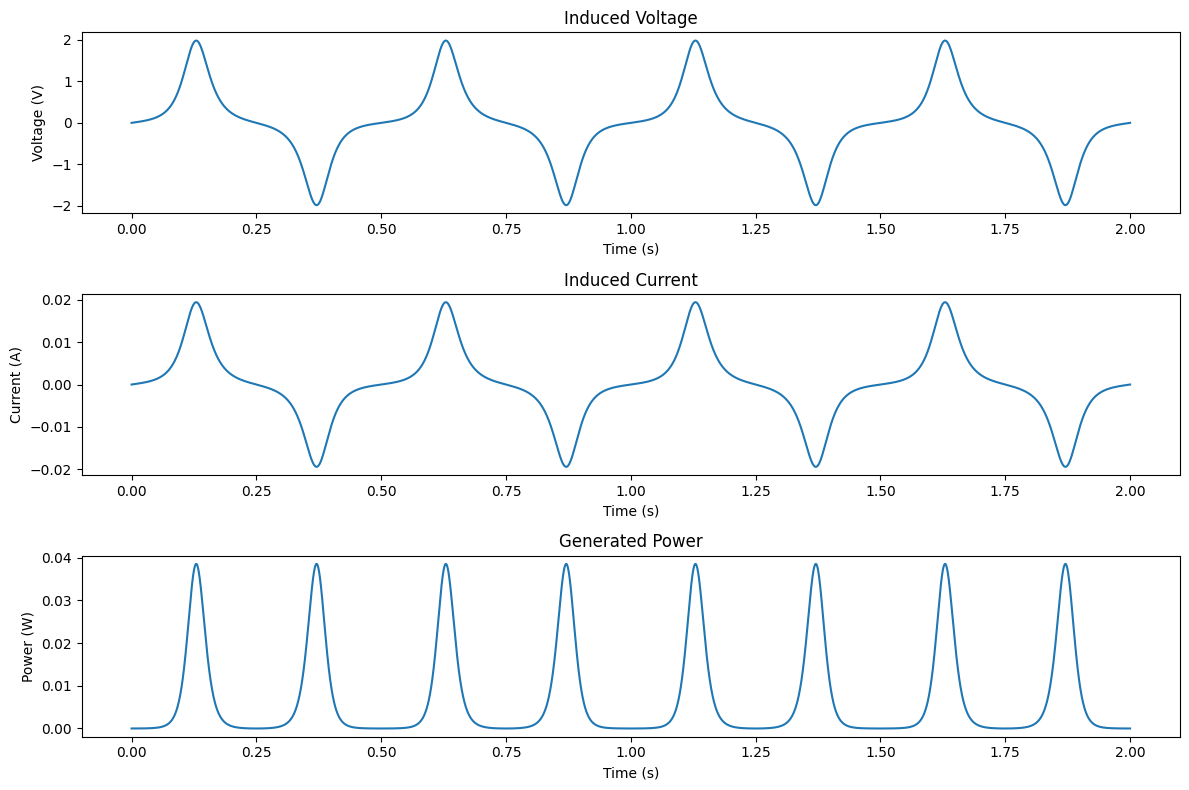

In [7]:
# Parameters
z0 = 0.03  # Amplitude of the motion (m)
frequency = 1  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)
m = 1  # Magnetic moment (A*m^2)
coil_length = 0.0445  # Length of the coil (m)

# Calculate the resistance of the coil
N = 5772  # Number of turns in the coil
coil_radius = 0.0105/2  # Radius of the coil in meters
d_wire = 0.0002   # Diameter of the wire in meters (0.2 mm)
wire_length = 2 * np.pi * coil_radius * N
wire_cross_section = np.pi * (d_wire / 2)**2
rho_copper = 1.68e-8  # Resistivity of copper in ohm meters
R = rho_copper * wire_length / wire_cross_section

# Time array
t = np.linspace(0, 2, 100000)  # Time from 0 to 2 seconds

# Magnet motion
z = z0 * np.sin(omega * t)
dz_dt = z0 * omega * np.cos(omega * t)

# Computational parameters
discretization = 1000  # Discretization of the coil

# Discretize the coil
segment_length = coil_length / discretization
z_segments = np.linspace(-coil_length / 2, coil_length / 2, discretization)




# Calculate the voltage across the coil by summing up the voltages across the coil segments.

V = calculate_voltage_old(t, z, z_segments, coil_radius, m, mu0, N, coil_length, segment_length)
plot(t, V, R)

Calculated Resistance:  39.298896000000006
Constant Power Generated:  0.00047055267083926413


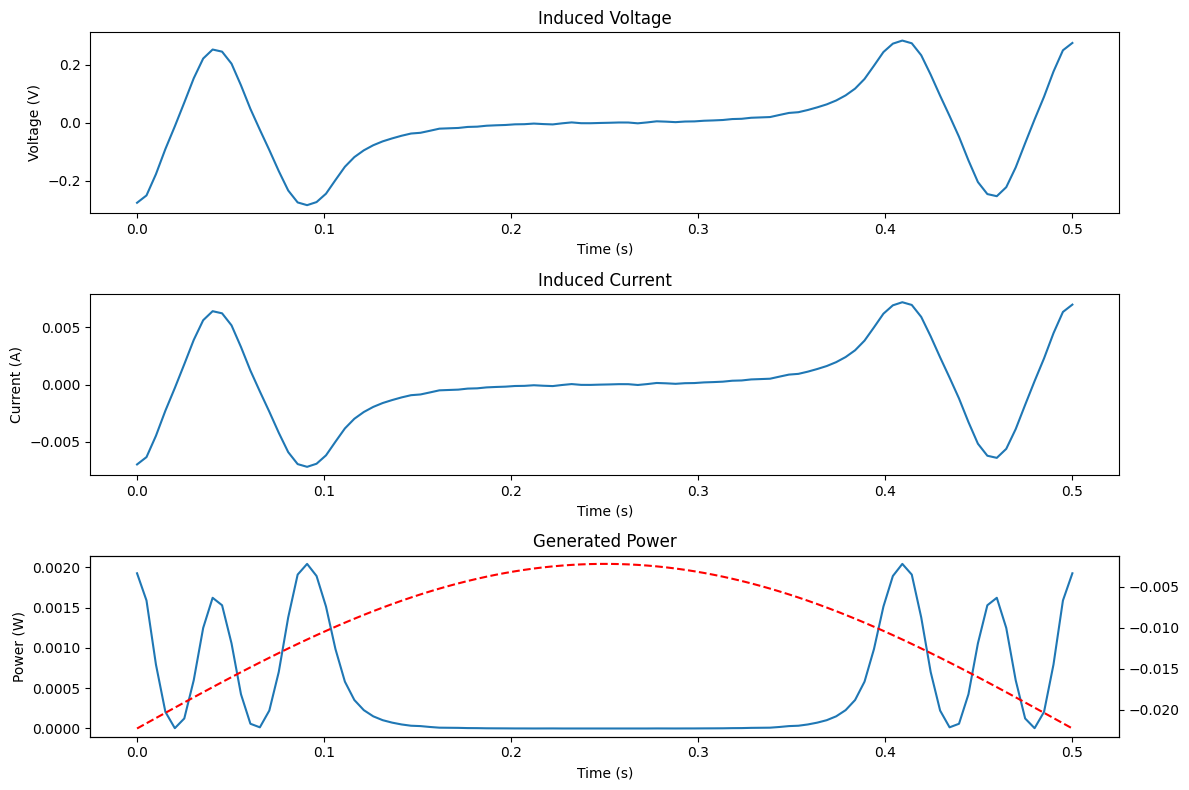

In [8]:
# Assume that the coil is the size of an aaa battery. The magnet is suspended isndie the coil and is oscillating up and down.


def calculate_inner_radius(outer_radius, coil_length, number_of_turns, wire_diameter):
    # Calculate the number of turns per layer
    turns_per_layer = coil_length / wire_diameter
    
    # Initialize variables
    remaining_turns = number_of_turns
    current_radius = outer_radius
    wire_length = 0
    
    # Loop through each layer and calculate the inner radius
    while remaining_turns > 0:
        if current_radius <= 0:
            raise ValueError("Invalid configuration: The number of turns and wire diameter do not fit into the outer radius.")
        
        # Calculate the number of turns in the current layer
        turns_in_layer = min(remaining_turns, turns_per_layer)
        
        # Calculate the length of wire in the current layer
        layer_length = 2 * np.pi * current_radius * turns_in_layer
        wire_length += layer_length
        
        # Subtract the current layer's thickness from the radius
        current_radius -= wire_diameter
        
        # Update remaining turns
        remaining_turns -= turns_in_layer
    
    inner_radius = current_radius
    if inner_radius <= 0:
        raise ValueError("Invalid configuration: The number of turns and wire diameter do not fit into the outer radius.")
    
    return inner_radius, wire_length
    

def calculate_resistance_of_coil(wire_length, d_wire=0.0002, rho=1.68e-8):
    """
    Calculate the resistance of the coil based on the wire length.
    """
    wire_cross_section = np.pi * (d_wire / 2)**2
    R = rho * wire_length / wire_cross_section
    return R


# Motion parameters
offset = -0.0445/2  # Offset of the motion (m)
amplitude = 0.02  # Amplitude of the motion (m)
frequency = 1  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)2

# Physical constants
magnetization = 1.27e6 # Magnetization of a neodymium magnet in A/m

coil_length = 0.0445  # Length of the coil (m)
coil_radius = 0.0105 / 2  # Radius of the coil (m)
N = 5772 / 2 # Number of turns in the coil

_, wire_length = calculate_inner_radius(coil_radius, coil_length, N, 0.0002)
R = calculate_resistance_of_coil(wire_length, 0.0002, 1.68e-8)

# The magnet radius must be slightly smaller than the coil radius.
magnet_radius = 0.01 / 2  # Radius of the magnet in meters
magnet_length = 0.001  # Length of the magnet in meters



magnet = create_cylinder_magnet(magnet_radius, magnet_length, magnetization)
magnet = create_optimized_multi_cylinder_magnet(magnet_radius, 0.003, 5, 0.0025, magnetization, use_alternation=True)



def calculate_voltage(t, z_func, r, N, coil_length, magnet, r_discretization=3, z_discretization=4, coil_orientation=[]):
    """
    Calculate the voltage across the coil by summing up the voltages across the coil segments.
    
    Parameters:
    - t: Time array
    - z_func: Function that takes t and returns z
    - z_segments: Position array of the coil segments
    - r: Radius of the coil
    - m: Magnetic moment
    - mu0: Permeability of free space
    - N: Number of turns in the coil
    - coil_length: Length of the coil
    - segment_length: Length of the coil segment
    - magnet: The magnet object used to calculate the magnetic flux density
    - coil_orientation: An array indicating at what points the sign of the coil direction is flipped. Starts with +. Every entry in coil_orientation must be smaller than coil_length.
    
    Returns:
    - Voltage across the coil (array)
    """

    # Assert that coil_orientation is sorted and that all values are smaller than coil_length and positive
    assert all([0 <= x <= coil_length for x in coil_orientation]), "coil_orientation must be a list of positive values smaller than coil_length."
    assert all([x < y for x, y in zip(coil_orientation, coil_orientation[1:])]), "coil_orientation must be sorted."
    
    z = np.vectorize(z_func)(t)

    z_segments = np.linspace(-coil_length / 2, coil_length / 2, z_discretization)  # Segments along the z-axis
    segment_length = coil_length / z_discretization  # Length of each segment
    flux_through_segments = calculate_flux(z, magnet, z_segments, r, r_discretization)
    
    # Calculate the rate of change of magnetic flux with respect to time
    dB_dt = np.gradient(flux_through_segments, t, axis=0)
    
    # Calculate the induced electric field
    E = -dB_dt / (2 * np.pi * r)

    # Compile a numpy array based on the coil_orientation array
    field_sign = np.ones(E.shape[1])
    previous_end = 0
    for index, z in enumerate(coil_orientation):
        start_index = int(previous_end / coil_length * z_discretization)
        end_index = int(z / coil_length * z_discretization)
        previous_end = z

        if index % 2 == 0:
            field_sign[start_index:end_index] = 1
        else:
            field_sign[start_index:end_index] = -1

    # Apply the sign of the last segment
    if len(coil_orientation) % 2 == 1:
        field_sign[int(previous_end / coil_length * z_discretization):] = -1
    
    #print("Field sign: ", field_sign)
    # print("Field sign: ", field_sign)

    # evaluate_at = z_discretization // 3
    # # Plot the magnetic flux at a specific position to debug.
    # plt.figure(figsize=(12, 2))
    # plt.plot(t, flux_through_segments[:, evaluate_at])
    # plt.title(f"Magnetic Flux at z={z_segments[evaluate_at]}")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Magnetic Flux (T*m^2)")
    # plt.show()


    # # Plot the field signs
    # plt.figure(figsize=(12, 2))
    # plt.plot(z_segments, field_sign)
    # plt.title(f"Field Sign at z={z_segments[evaluate_at]}")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Field Sign")
    # plt.show()


    # # #print("Magnet was at z = ", z[evaluate_at])
    # # #Plot the electric field at a specific position to debug.
    # plt.figure(figsize=(12, 2))
    # plt.plot(t, E[:, evaluate_at])
    # plt.title(f"Electric Field at z={z_segments[evaluate_at]}")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Electric Field (V/m)")
    # plt.show()


    # Calculate the parallel component of the wire
    parallel_component_of_the_wire = 2 * np.pi * r * N / coil_length * segment_length
    
    # Calculate the total voltage across the coil
    V = np.sum(E * field_sign * parallel_component_of_the_wire, axis=1)
    
    return V


# Time array
t = np.linspace(0, 0.5, 100)  # Time from 0 to 1 seconds

equation_of_motion = lambda t: amplitude * np.sin(omega * t) + offset
# Calculate the voltage across the coil by summing up the voltages across the coil segments
V = calculate_voltage(t, equation_of_motion, coil_radius, N, coil_length, magnet, r_discretization=20, z_discretization=100)

plot(t, V, R, equation_of_motion)
#0.009


Wire length:  3.184758136650117
Inner radius:  0.0044424
Magnet dimensions:  Radius:  0.0043424 Length:  0.012


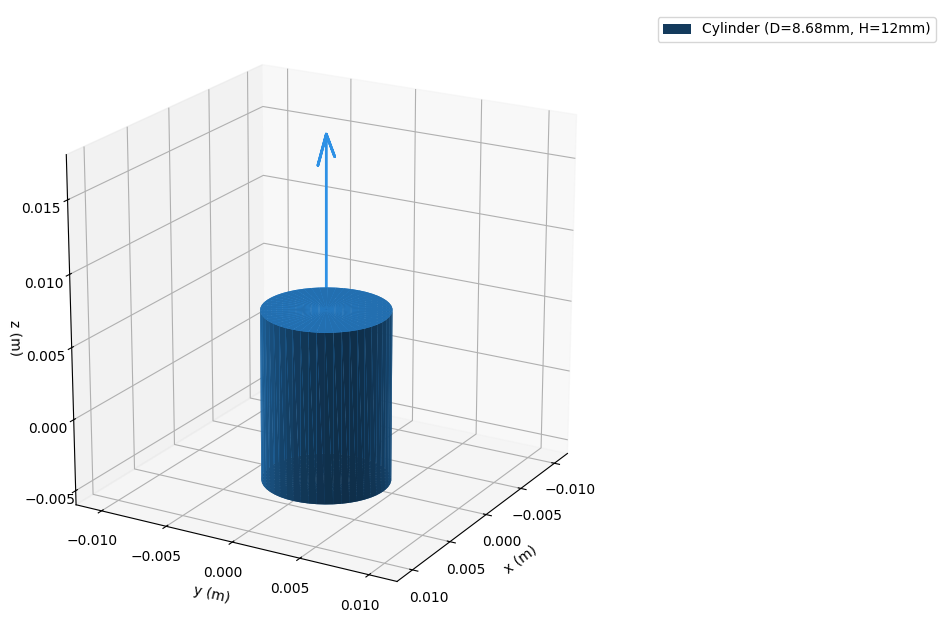

Calculated Resistance:  0.8355899784145714
Constant Power Generated:  0.0023214639321160525


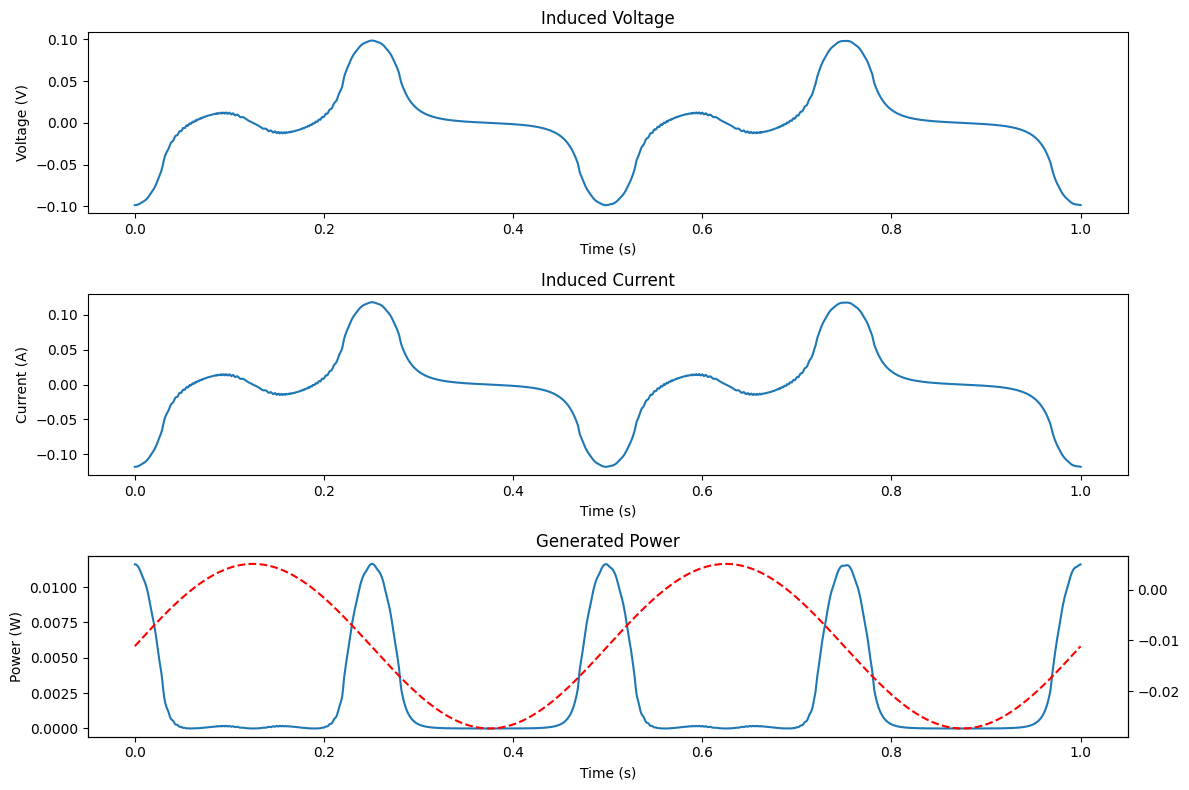

In [39]:
# This is the simulation of a design that consists of two coils and a magnet swinging inside the coils. At rest the magnet is positioned between the coils.
# The generator should have the dimensions of an AAA battery.



# Parameters

# Physical constants
magnetization = 1.27e6 # Magnetization of a neodymium magnet in A/m
magnetization = 9e5 # Low estimate for N48 neodymium magnet


outer_radius = 0.0105 / 2  # Radius of AAA battery (m)
outer_length = 0.0445  # Length of AAA battery (m) (Could in principle be longer as the battery compartment is open on one side.)
number_of_turns = 100  # Number of turns in the coil
coil_length = outer_length / 2  # Length of the coil (m)
coil_radius = 0.0105 / 2  # Radius of the coil (m)
wire_diameter = 0.00016 # Diameter of the wire in meters (0.16 mm) (34 AWG wire)
wire_diameter = 0.0001016 # 38 AWG wire
wire_diameter = 0.0004038 # 26 AWG wire

inner_radius, wire_length = calculate_inner_radius(outer_radius, coil_length, number_of_turns, wire_diameter)
print("Wire length: ", wire_length)
R = calculate_resistance_of_coil(wire_length, wire_diameter, 1.68e-8)
print("Inner radius: ", inner_radius)
magnet_radius = inner_radius - 0.0001
magnet_length = 0.012  # Length of the magnet in meters
print("Magnet dimensions: ", "Radius: ", magnet_radius, "Length: ", magnet_length)
magnet = create_cylinder_magnet(magnet_radius, magnet_length, magnetization)


# Now we calculate the voltage accross, say, the right coil. The total voltage is the sum of the voltages across the two coils. 
# The layout is symmetric so the two final voltage should be twice the voltage of the right coil. We will set the origin of the z-axis to the middle of the right coil.

# Determine the resting position of the magnet assuming that there is a separation between the two coils and the magnet is in the middle.
resting_position = - coil_length / 2

# The magnet is oscillating up and down with a frequency of 2 Hz and an amplitude of 3 cm.
max_oscillation_amplitude = coil_length - magnet_length / 2
amplitude = max_oscillation_amplitude #outer_length/3  # Amplitude of the motion (m) Assuming that not the full length of the module can be used.
frequency = 2  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)
equation_of_motion = lambda t: amplitude * np.sin(omega * t) + resting_position

# Time array
t = np.linspace(0, 1, 1000)  # Time from 0 to 1 seconds discretized into 1000 points

# Voltage across the right coil
V_right = calculate_voltage(t, equation_of_motion, coil_radius, number_of_turns, coil_length, magnet, r_discretization=20, z_discretization=100)

# Total voltage is twice the voltage of the right coil. The coils must be connected so that the voltages add up.
V = 2 * V_right


plot(t, V, R*2, equation_of_motion)


In [10]:
def calculate_power(voltage, resistance):
    return (voltage**2) / resistance

def plot_power_vs_turns(outer_radius, coil_length, outer_length, coil_separation, frequency, magnetization, wire_diameter, turns_range):
    amplitude = outer_length / 3
    omega = 2 * np.pi * frequency
    resting_position = -coil_length / 2 - coil_separation / 2
    equation_of_motion = lambda t: amplitude * np.sin(omega * t) + resting_position
    t = np.linspace(0, 1, 1000)
    
    average_powers = []
    for turns in turns_range:
        try:
            inner_radius, wire_length = calculate_inner_radius(outer_radius, coil_length, turns, wire_diameter)
        except ValueError:
            average_powers.append(0)
            continue
        magnet_radius = inner_radius - 0.0001
        magnet_length = 0.01
        magnet = create_cylinder_magnet(magnet_radius, magnet_length, magnetization)
        V_right = calculate_voltage(t, equation_of_motion, outer_radius, turns, coil_length, magnet, 20, 100)
        V = 2 * V_right
        R = 1.68e-8 * (turns * coil_length) / (np.pi * (wire_diameter / 2)**2)  # Simplified resistance calculation
        R = calculate_resistance_of_coil(wire_length, wire_diameter, 1.68e-8)
        power = calculate_power(V, R)
        average_power = np.mean(power)
        average_powers.append(average_power)
    
    plt.figure(figsize=(10, 6))
    plt.plot(turns_range, average_powers, label='Average Power Output')
    plt.xlabel('Number of Turns')
    plt.ylabel('Average Power (W)')
    plt.title('Average Power Output vs. Number of Turns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
outer_radius = 0.0105 / 2
outer_length = 0.0445 / 2
coil_length = outer_length / 2
coil_separation = 0.0001
frequency = 2
magnetization = 1.27e6
wire_diameter = 0.00016
wire_diameter = 0.0002032 # 32 AWG wire
wire_diameter = 0.0001601 # 34 AWG wire
wire_diameter = 0.0001016 # 38 AWG wire
#wire_diameter = 0.0008128 # 20 AWG wire
wire_diameter = 0.0004038 # 26 AWG wire

# Range of number of turns to evaluate
turns_range = np.arange(1, 3000, 50)

# Plot the average power output vs. number of turns
#plot_power_vs_turns(outer_radius, coil_length, outer_length, coil_separation, frequency, magnetization, wire_diameter, turns_range)

In [11]:
def plot_figure(x, y, x_label=None, y_label=None, title=None, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

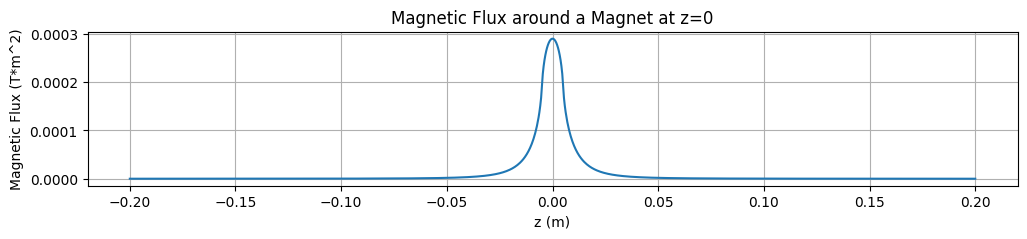

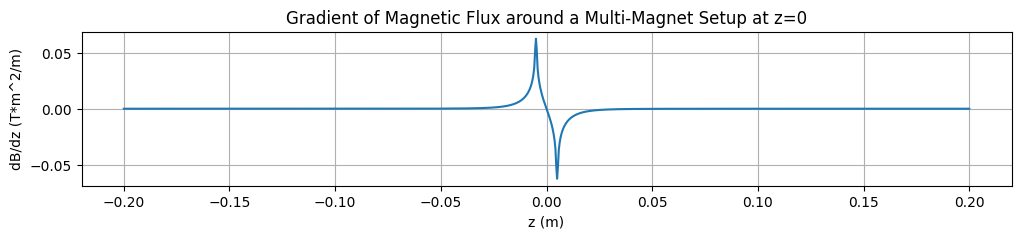

Absolute Integral of the Gradient of dB/dz:  1.4466080470136697


In [12]:
# Design number two: 
# The hypothesis is that in the old approach the parts of the coil that are far away from the magnet are not contributing significantly to the power output.

# Test Parameters
radius = 0.01
length = 0.01

# Plot the magnetic flux around a magnet at z = 0.
magnet = create_cylinder_magnet(radius, length, 1.27e6)
z_segments = np.linspace(-0.2, 0.2, 1000)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plot_figure(z_segments, flux.squeeze(), 'z (m)', 'Magnetic Flux (T*m^2)', 'Magnetic Flux around a Magnet at z=0', (12,2))

# When the magnet moves inside the coil, the electric field induced at each point is proportional to the rate of change of the magnetic flux at that point.
# If the magnet moves to the right, the change in magnetic flux is: velocity * dB/dx. I.e. the higher dB/dx, the higher the induced electric field for a given velocity.
# Note that dB/dx is the gradient of the figure plotted above.
# Let us plot dB/dx.
gradient = np.gradient(flux, z_segments, axis=1)
plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())

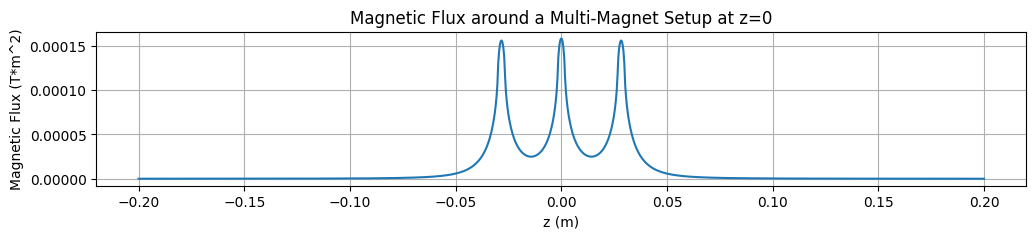

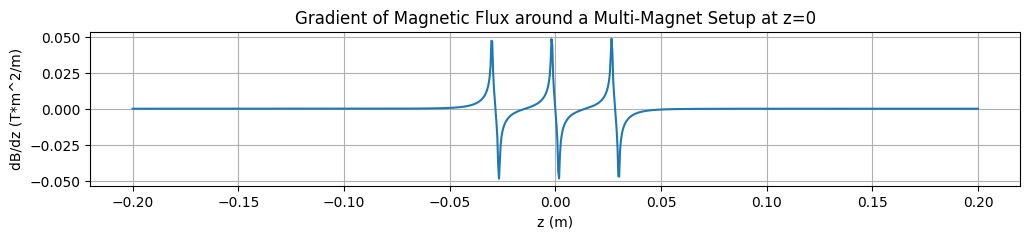

Absolute Integral of the Gradient of dB/dz:  2.096198582673708


In [13]:
# The challenge is to find a way to maximize the absolute value integral of the gradient of dB/dx over the coil length by modifying the magnet setup that is moving.
# In the above figures only one magnet is positioned at z=0. 
# What if there was a setup with multiple magnets that are positioned along the z-axis at different positions?
# To acount for the fact that we will be adding magnets we will need to decrease their length to make fair comparisons later.
# By adding more magnets we can increase the number of peaks in the dB/dx plot, thus increasing the integral of the gradient of dB/dx over the coil length.

# Let us plot the magnetic flux and the gradient of the magnetic flux for a setup with multiple magnets.
# We will start with 3 magnets positioned with a gap that is roughly determined by eye from the above figure to make the peaks as dense as possible.
magnet = create_optimized_multi_cylinder_magnet(radius, length / 3, 3, 0.025, 1.27e6, use_alternation=False)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plot_figure(z_segments, flux.squeeze(), 'z (m)', 'Magnetic Flux (T*m^2)', 'Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
gradient = np.gradient(flux, z_segments, axis=1)
plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())

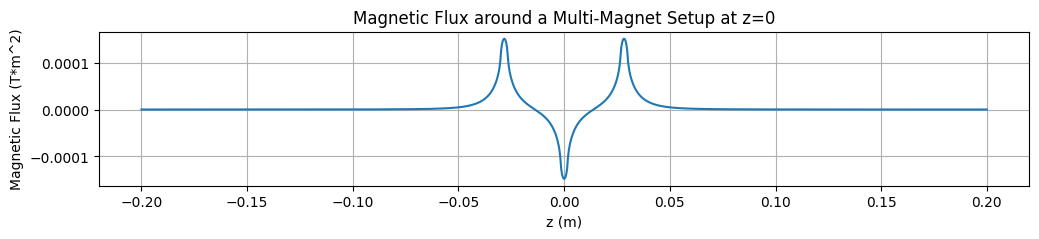

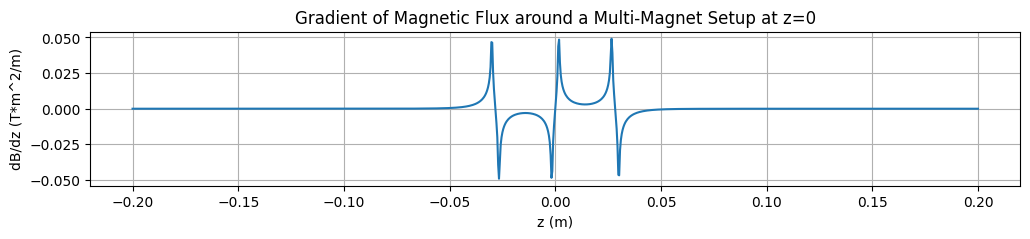

Absolute Integral of the Gradient of dB/dz:  2.238100208240435


In [14]:
# The absolute integral of the gradient of dB/dx is significantly higher for the multi-magnet setup even though the total volume of the magnets is the same.
# Let us optimize this even further. By the superoposition principle the magnetic field at a point is the sum of the magnetic fields of the individual magnets.
# It follows that dB/dx = dB1/dx + dB2/dx + dB3/dx. Ideally, we would like to have the same sign for all dB_i/dx so that they do not cancel each other out.
# For example between any two peaks we find that the gradient due to the left magnet it negative and the gradient due to the right magnet is positive.
# Luckily we can simply flip the polarity of every other magnet to cancel this. We use the use_alternation=True flag to do this.

# In the previous step we aligned the three magnets so that their fields have minimal overlap. (At least roughly by eye.)
# What if we moved the magnets closer together so that their fields overlap more?

magnet = create_optimized_multi_cylinder_magnet(radius, length / 3, 3, 0.025, 1.27e6, use_alternation=True)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plot_figure(z_segments, flux.squeeze(), 'z (m)', 'Magnetic Flux (T*m^2)', 'Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
gradient = np.gradient(flux, z_segments, axis=1)
plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())

In [15]:
# The integral is again higher. We can expect the effect of switching polarity to be more pronounced with smaller gaps where the cancellation effect is stronger.

# When will the effect start to be destructive?

In [50]:
import numpy as np
from tqdm.notebook import tqdm

import itertools

def brute_force_optimize(radius, magnetization, use_alternation, magnet_lengths, gaps, number_of_magnets, top_n=5):
    """
    Brute force optimization to find the best combinations of parameters that maximize the absolute integral
    of the gradient of dB/dz.
    
    Parameters:
    - radius: Radius of the cylinder (m)
    - magnetization: Magnetization vector (A/m)
    - use_alternation: If set to True, alternates the polarity of neighboring magnets
    - magnet_lengths: Array of possible values for magnet lengths
    - gaps: Array of possible values for gaps between magnets
    - number_of_magnets: Array of possible values for the number of magnets
    - top_n: Number of best parameter sets to return
    
    Returns:
    - List of tuples containing the best parameter sets and their corresponding function values
    """
    results = []
       # Create all combinations of the parameter values
    all_combinations = list(itertools.product(magnet_lengths, gaps, number_of_magnets))
    
    # Filter out invalid configurations
    valid_combinations = [(magnet_length, gap, num_magnet) for (magnet_length, gap, num_magnet) in all_combinations if magnet_length * num_magnet + gap * (num_magnet - 1) < max_size]    

    # Iterate over valid configurations
    for magnet_length, gap, num_magnets in tqdm(valid_combinations, total=len(valid_combinations)):
       
        # Create the magnet system
        magnet = create_optimized_multi_cylinder_magnet(radius, magnet_length, num_magnets, gap, magnetization, use_alternation)
        
        # Calculate the magnetic flux and gradient
        z_segments = np.linspace(-0.1, 0.1, 500)
        flux = calculate_flux([0], magnet, z_segments, radius, 20)
        gradient = np.gradient(flux, z_segments, axis=1)
        integral_gradient = np.abs(gradient).sum()
        
        # Store the result
        results.append(((magnet_length, gap, num_magnets), integral_gradient))
    
    # Sort the results by the integral_gradient value (descending order)
    results.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top_n results
    return results[:top_n]


# Parameters
coil_radius = 0.0105 / 2  # Radius in meters
max_size = 0.0445 - 0.008# The max size of the full magnet assembly. Restrict to the size of an AAA battery - any space needed for the spring / magnet keeping the assembly in the middle of the coil.
magnetization = 1.27e6  # Magnetization in A/m
use_alternation = True  # Set to True to alternate polarity
radius = 0.0043424

# Possible values for optimization
max_magnet_length = max_size
magnet_lengths = [0.006, 0.008, 0.013 ]#np.linspace(0.001, max_magnet_length, 100)  # Array of possible values for magnet lengths
max_gap_size = max_size / 2
gaps = np.linspace(0, max_gap_size, 100)  # Array of possible values for gaps between magnets
number_of_magnets = np.arange(1, 20)  # Array of possible values for the number of magnets

# Optimize the magnet system
top_results = brute_force_optimize(radius, magnetization, use_alternation, magnet_lengths, gaps, number_of_magnets, top_n=20)

# Print the top results
for idx, (params, value) in enumerate(top_results):
    print(f"Rank {idx + 1}:")
    print(f"  Magnet Length: {params[0]} m")
    print(f"  Gap: {params[1]} m")
    print(f"  Number of Magnets: {params[2]}")
    print(f"  Objective Function Value: {value}")



  0%|          | 0/684 [00:00<?, ?it/s]

Rank 1:
  Magnet Length: 0.006 m
  Gap: 0.0 m
  Number of Magnets: 6
  Objective Function Value: 1.4053711524311603
Rank 2:
  Magnet Length: 0.006 m
  Gap: 0.0014747474747474746 m
  Number of Magnets: 5
  Objective Function Value: 1.319195179041452
Rank 3:
  Magnet Length: 0.006 m
  Gap: 0.0012904040404040403 m
  Number of Magnets: 5
  Objective Function Value: 1.3070075290271936
Rank 4:
  Magnet Length: 0.006 m
  Gap: 0.001106060606060606 m
  Number of Magnets: 5
  Objective Function Value: 1.2928037220349946
Rank 5:
  Magnet Length: 0.006 m
  Gap: 0.0009217171717171716 m
  Number of Magnets: 5
  Objective Function Value: 1.2786253828334204
Rank 6:
  Magnet Length: 0.006 m
  Gap: 0.0007373737373737373 m
  Number of Magnets: 5
  Objective Function Value: 1.2625228346393742
Rank 7:
  Magnet Length: 0.006 m
  Gap: 0.000553030303030303 m
  Number of Magnets: 5
  Objective Function Value: 1.2457587797093237
Rank 8:
  Magnet Length: 0.008 m
  Gap: 0.0014747474747474746 m
  Number of Magnets

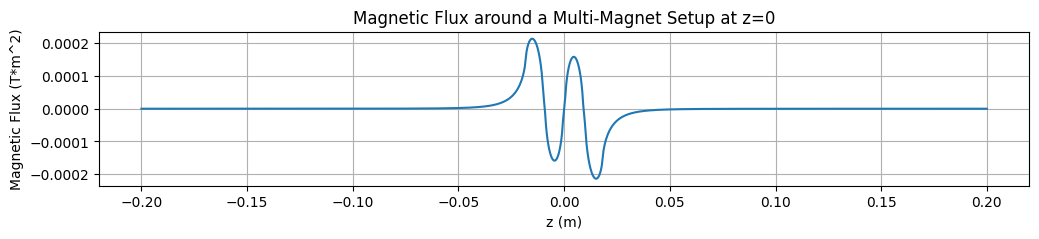

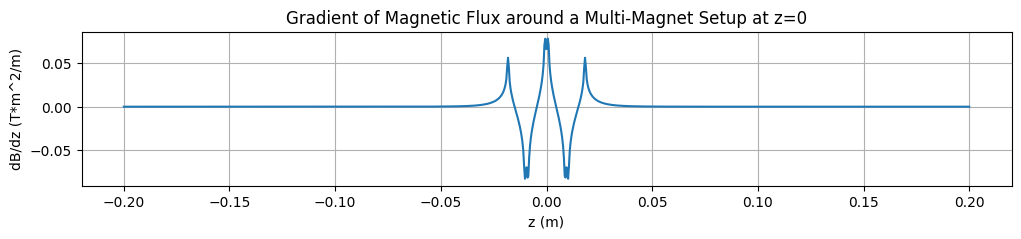

Absolute Integral of the Gradient of dB/dz:  3.7178191506368945


In [ ]:
magnet_length = top_results[0][0][0]
gap = top_results[0][0][1]
num_magnets = top_results[0][0][2]
magnet = create_optimized_multi_cylinder_magnet(radius, magnet_length, num_magnets, gap, 1.27e6, use_alternation=use_alternation)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plot_figure(z_segments, flux.squeeze(), 'z (m)', 'Magnetic Flux (T*m^2)', 'Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
gradient = np.gradient(flux, z_segments, axis=1)
plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())

#3.5802125761088543

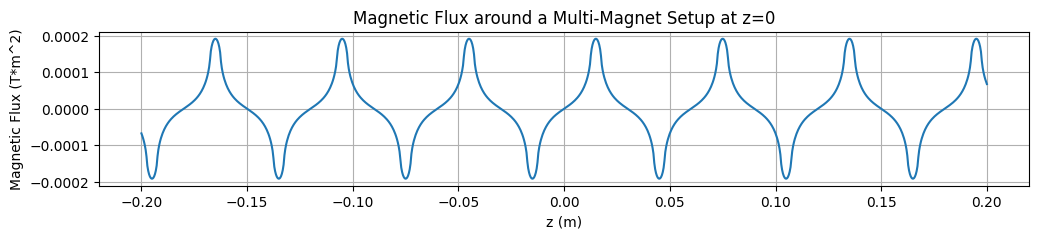

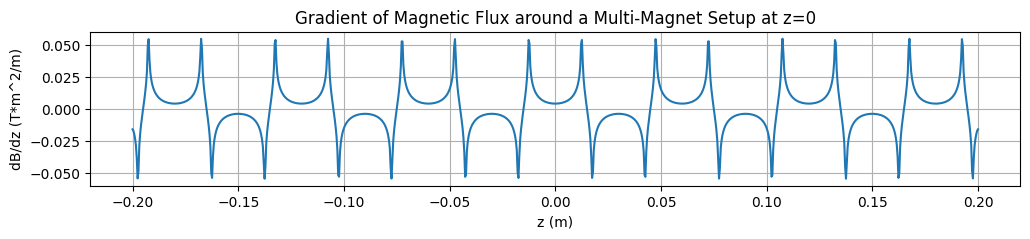

Absolute Integral of the Gradient of dB/dz:  13.056556082078988


In [ ]:
# We have found the configuration that maximizes the integral of the gradient of the magnetic flux.
# Next we will try to figure out how to optimally build the coil around the magnet assembly.

# Imagine a single coil that is wound around the magnet assembly. Then the total output voltage is proportional to integral of the gradient of dB/dz over the coil length.
# Note that it is not the absolute integral that is always positive and whenever the magnet is fully inside the coil the integral vanishes as the peaks cancel each other out.
# To optimize this we might want to split the coil into segments with differing winding directions. Then by proper alignment we the peaks of the dB/dz gradients will add up.
# Is there some optimal configuration of the coil segments that maximizes the integral of the gradient of the magnetic flux?

# To gain some insight into this we will start with a simpler case of a two magnet system.

magnet = create_optimized_multi_cylinder_magnet(radius, length / 2, 100, 0.025, 1.27e6, use_alternation=True)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plot_figure(z_segments, flux.squeeze(), 'z (m)', 'Magnetic Flux (T*m^2)', 'Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
gradient = np.gradient(flux, z_segments, axis=1)
plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())

In [ ]:
# The first instinct is to split the coil exactly there where the gradient changes sign. This way the peaks of the dB/dz gradients will add up.
# However, this is concidering only the case where the magnet is at z=0
# In actuality the magnet is moving so we need to concider the gradient at all positions of the magnet.

# Define S(z) a function that indicates the winding direction of the coil at position z.
# It is positive when the coil is oriented clockwise, negative when the coil is oriented counter-clockwise and zero when no coil is present.
# Define V'(x) an instantaneous pseudo-voltage function that is a proxy for the voltage when the magnet is at position x.
# It is defined as the integral of S(x-z) * dΦ/dz, over z ranging over the coil length.
# We need to find a function S(z) that maximizes the integral of V' over the coil length.

# Define an interval I = [-L/2, L/2] and an arbitrary interval M
# Define S(x) a sign function that is either 1 or -1 at position z in the interval I. It is 0 otherwise.
# Define V(z) = integral(S(x-z) * dΦ(x)/dz, x, [-inf, inf])
# Define P = integral(V(z), z, M) 
# We ne to find the optimal function S s.t. the integral P is maximized. We also want to analyze the effect of the choice of M on the maximal value of P.




In [ ]:
# We have made the following simplifications in the above argumentation.
# - We have neglected the movement of the magnet and dismissed it as a constant that can be omitted when searching for the optimal coil configuration.
# - While optimizing P we assumed that the full magnet system penetrates the coil from -infinity to +infinity. In reality it oscillates within the coil.

# Does the optimal S(x) change if we take into account the motion of the magnet?
# Assume that the speed of the magnet is f(x) at position x)

# But until now we have ignored the actual motion of the magnet. The question is if the actual power output of the system cahnges if S(x) 

Max Oscillation Amplitude:  0.01475
Inner radius:  0.0044424
Magnet dimensions. Number:  1 Radius:  0.0043424 Length:  0.015


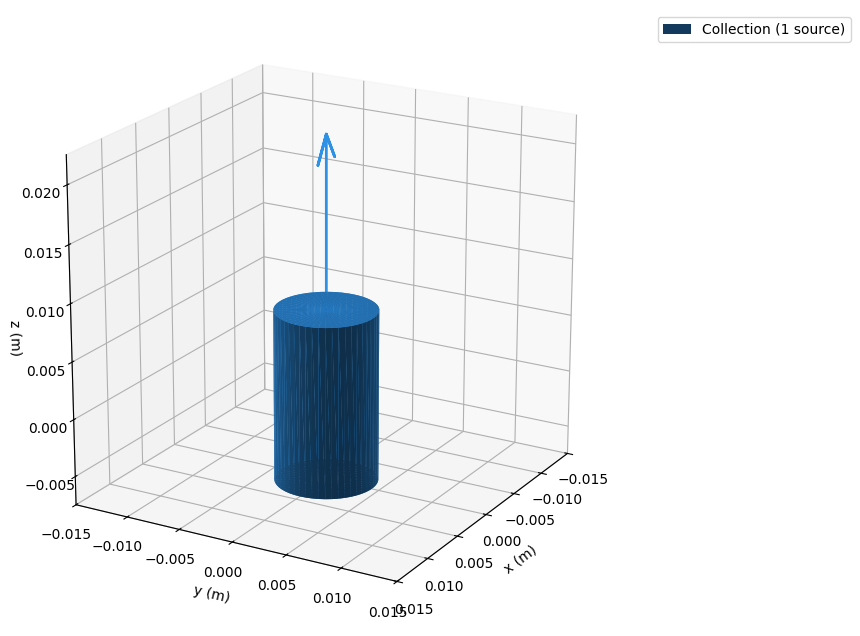

Coil orientation points:  [0.02225]


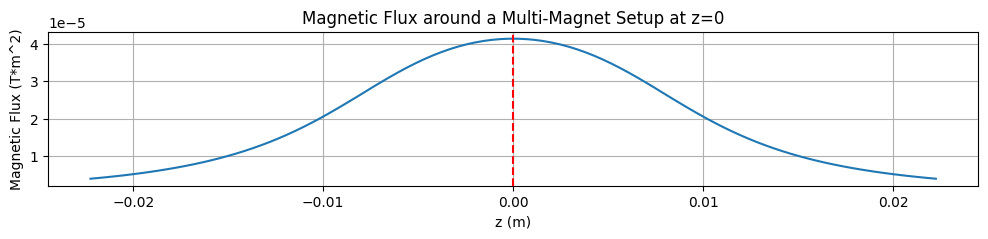

Absolute Integral of the Gradient of dB/dz:  0.1674791765612314


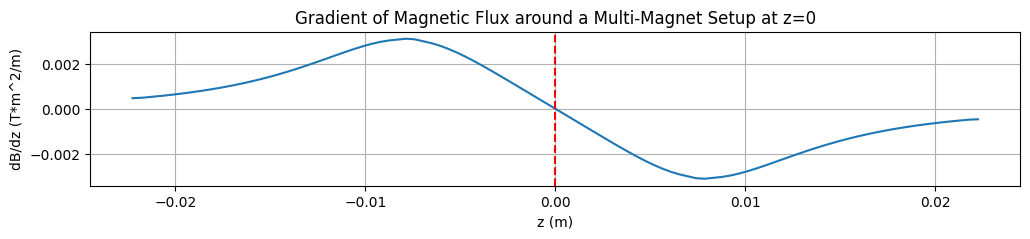

Calculated Resistance:  0.8355899784145714
Constant Power Generated:  0.007385839667826284


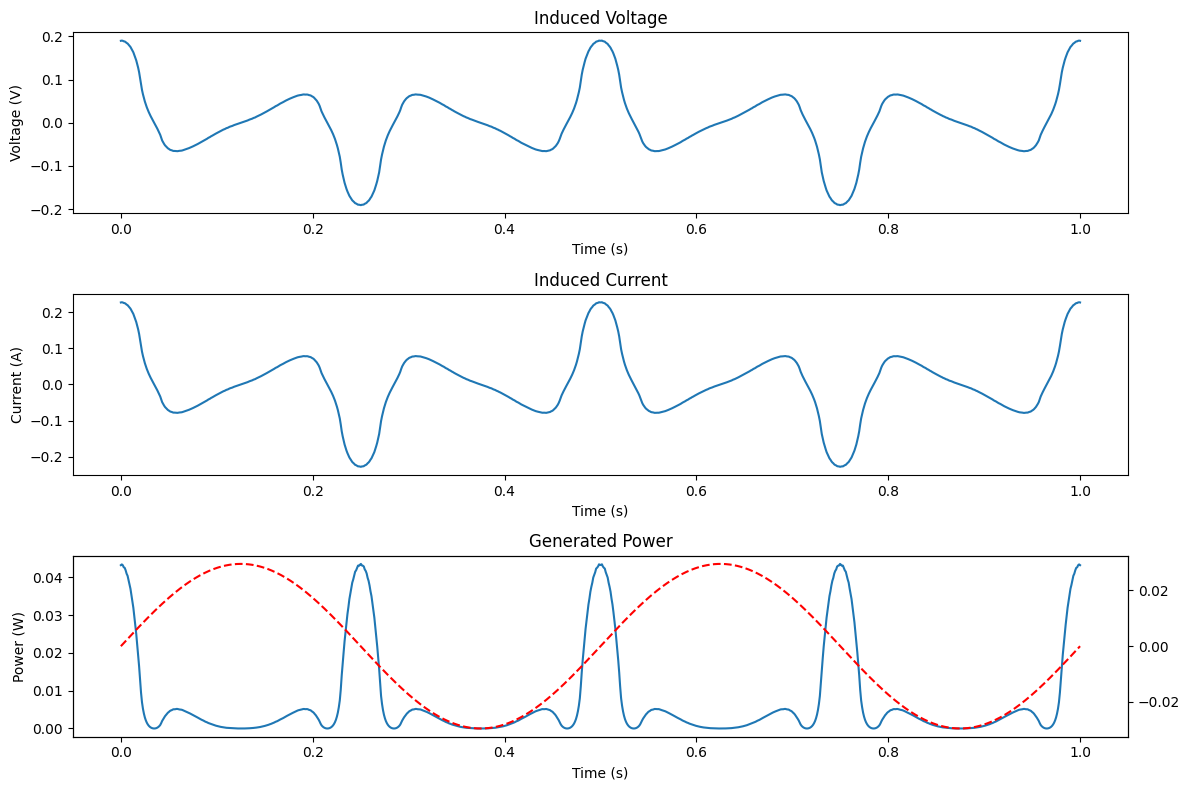

In [58]:
# To gain some intuition we try out different configurations manually.

# Parameters
magnetization = 9e5
outer_length = 0.0445 # Length of the generator module (m)
outer_radius = 0.0105 / 2 # Radius of the generator modules (m)
number_of_magnets = 1 # 17 # Number of magnets.
magnet_height = 0.015 #
magnet_spacing = 0.002# 0.00147
magnet_assembly_height = number_of_magnets * magnet_height + (number_of_magnets - 1) * magnet_spacing
max_oscillation_amplitude = (outer_length - magnet_assembly_height) / 2
assert(max_oscillation_amplitude > 0)
print("Max Oscillation Amplitude: ", max_oscillation_amplitude)


number_of_turns = 200
wire_diameter = 0.0004038 # 26 AWG wire
inner_radius, wire_length = calculate_inner_radius(outer_radius, outer_length, number_of_turns, wire_diameter)

R = calculate_resistance_of_coil(wire_length, wire_diameter, 1.68e-8)
print("Inner radius: ", inner_radius)
magnet_radius = inner_radius - 0.0001
print("Magnet dimensions. Number: ", number_of_magnets , "Radius: ", magnet_radius, "Length: ", magnet_height)
magnet = create_optimized_multi_cylinder_magnet(magnet_radius, magnet_height, number_of_magnets, magnet_spacing, magnetization, use_alternation=True)

plot_magnet(magnet)
# Plot magnet field


# Swap coil sign at the points where the magnets are located in rest.
offset = max_oscillation_amplitude + magnet_height / 2
coil_orientation = [ offset + i * (magnet_height + magnet_spacing)  for i in range(number_of_magnets)]
print("Coil orientation points: ", coil_orientation)

# Plot the magnetic flux around a magnet at z = 0. Draw lines at the positions of coil_orientation switches.
z_segments = np.linspace(-outer_length/2, outer_length/2, 100)
flux = calculate_flux([0], magnet, z_segments, 0.01, 100)
plt.figure(figsize=(12,2))
plt.plot(z_segments, flux.squeeze())
plt.xlabel("z (m)")
plt.ylabel("Magnetic Flux (T*m^2)")
plt.title("Magnetic Flux around a Multi-Magnet Setup at z=0")
# Draw vertical lines at the coil_orientation points
for orientation in coil_orientation:
    plt.axvline(x=orientation - outer_length/2 , color='r', linestyle='--')

plt.grid(True)
plt.show()

# Plot the gradient of the magnetic flux
gradient = np.gradient(flux, z_segments, axis=1)
#plot_figure(z_segments, gradient.squeeze(), 'z (m)', 'dB/dz (T*m^2/m)', 'Gradient of Magnetic Flux around a Magnet at z=0', (12,2))
print("Absolute Integral of the Gradient of dB/dz: ", np.abs(gradient).sum())
plt.figure(figsize=(12,2))
plt.plot(z_segments, gradient.squeeze(), label='Gradient of Magnetic Flux')
plt.xlabel("z (m)")
plt.ylabel("dB/dz (T*m^2/m)")
plt.title("Gradient of Magnetic Flux around a Multi-Magnet Setup at z=0")
# Draw vertical lines at the coil_orientation points
for orientation in coil_orientation:
    plt.axvline(x=orientation - outer_length/2 , color='r', linestyle='--')

plt.grid(True)
plt.show()



# The magnet is oscillating up and down with a frequency of 2 Hz and an amplitude of 3 cm.
oscillation_amplitude = 2 * max_oscillation_amplitude  # Amplitude of the motion (m)
frequency = 2  # Frequency of the motion (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)
equation_of_motion = lambda t: oscillation_amplitude * np.sin(omega * t)
# Time array
t = np.linspace(0, 1, 1000)  # Time from 0 to 1 seconds discretized into 1000 points


# Voltage across the right coil
V = calculate_voltage(t, equation_of_motion, outer_radius, number_of_turns, outer_length, magnet, r_discretization=20, z_discretization=200, coil_orientation=coil_orientation)

plot(t, V, R, equation_of_motion)

#  0.0030215229115330535
# 

In [ ]:
# By splitting the one magnet generator into an n magnet generator we can make use of the coil more efficient.
# Here we simulate a model with n magnets that are aligned along the z axis. The magnets have a gap between them.

# There are a multitude of open parameters that influence the performance of the generator.
#  - The number of magnets
#  - The length of the magnets
#  - The gap between the magnets
#  - The radius of the magnets
#  - The diameter of the coil wire 
#  - The amplitude of the motion
# 
# The amplitude of the motion depends on 

# The solution is to repeat the original design n times in the same space.

# Parameters
outer_length = 0.0445 # Length of the generator module (m)
outer_radius = 0.0105 / 2 # Radius of the generator modules (m)
number_of_magnets = 3 # Number of magnets.
magnet_height = 0.008
magnet_spacing = 0.0001
magnet_assembly_height = number_of_magnets * magnet_height + (number_of_magnets - 1) * magnet_spacing
oscillation_amplitude = (outer_length - magnet_assembly_height) / 2
assert(oscillation_amplitude > 0)


# Here we try to find the optimal configuration of the generator module.
# We will search for the optimal values of the following parameters:
# - Number of magnets in the module
def calculate_power(outer_radius, outer_length, number_of_magnets, frequency, magnetization, wire_diameter, number_of_turns):
    coil_length = outer_length / 2
    amplitude = outer_length / 3
    omega = 2 * np.pi * frequency
    resting_position = -coil_length / 2 - coil_separation / 2
    equation_of_motion = lambda t: amplitude * np.sin(omega * t) + resting_position
    t = np.linspace(0, 1, 1000)
    
    try:
        inner_radius, wire_length = calculate_inner_radius(outer_radius, coil_length, number_of_turns, wire_diameter)
    except ValueError:
        return 0
    
    magnet_radius = inner_radius - 0.0001
    magnet_length = 0.01
    magnet = create_optimized_multi_cylinder_magnet(magnet_radius, magnet_length, number_of_magnets, gap, magnetization, use_alternation=True)
    V_right = calculate_voltage(t, equation_of_motion, outer_radius, number_of_turns, coil_length, magnet, 20, 100)
    V = 2 * V_right
    R = calculate_resistance_of_coil(wire_length, wire_diameter, 1.68e-8)
    power = calculate_power(V, R)
    average_power = np.mean(power)
    return average_power







/Users/sebastian/Documents/Aalto/Savox Battery Booster/python/venv/lib/python3.12/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cylinder(id=5112699104) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/Users/sebastian/Documents/Aalto/Savox Battery Booster/python/venv/lib/python3.12/site-packages/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cylinder(id=4693669360) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()


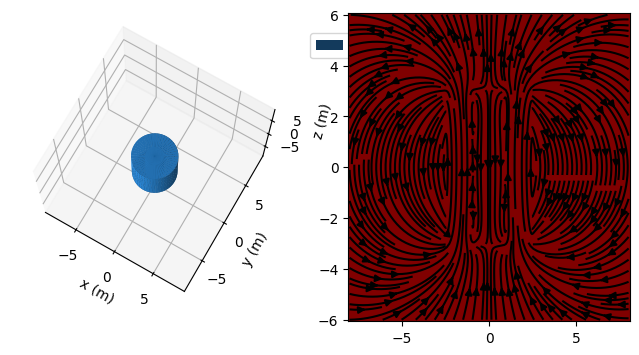

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from magpylib.magnet import Cylinder
import magpylib as magpy

# create collection of two magnets
s1 = Cylinder(magnetization=[0,0,1000], dimension=[5,6])
s2 = Cylinder(magnetization=[0,0,-1000], dimension=[2,6])
c = magpy.Collection(s1,s2)

# create positions
xs = np.linspace(-8,8,100)
zs = np.linspace(-6,6,100)
posis = [[x,0,z] for z in zs for x in xs]

# calculate field and amplitude
B = [c.getB(pos) for pos in posis]
Bs = np.array(B).reshape([100,100,3]) #reshape
Bamp = np.linalg.norm(Bs,axis=2)

# define figure with a 2d and a 3d axis
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# add displaySystem on ax1

magpy.show(c, canvas=ax1,suppress=True)
ax1.view_init(elev=75)

# amplitude plot on ax2
X,Z = np.meshgrid(xs,zs)
ax2.pcolor(xs,zs,Bamp,cmap='jet',vmin=-200)

# plot field lines on ax2
U,V = Bs[:,:,0], Bs[:,:,2]
ax2.streamplot(X,Z,U,V,color='k',density=2)

#display
plt.show()